# Reciprocal Relationship between Bartering and Selling
- When it comes to game exchange, do people prefer to exchange the game with someone who has exchanged before or someone who has not exchanged before? 
- What's the difference between game sales and game exchange?

Here, we use logistic regression.

## 0. Load the data

In [1]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load the data from pickle file
with open('data/transaction_history_all.pickle', 'rb') as f:
    data = pickle.load(f)

# Choose only the data before 2019-01-01
data = data.loc[data['created_utc']<='2018-12-31']

In [3]:
# with open(("./data/df_pre2019_original.pickle"), 'rb') as handle:
#     data = pickle.load(handle)
# data.shape

## 1. Preprocessing
- The bot may record wrongly the confirmantion.
- Some Reddit users may delete their accounts.

**We ignore these cases by deleting these rows.**

In [4]:
data.loc[data['author']==data['reply_author']].shape

(97, 11)

In [5]:
data = data.loc[data['author']!=data['reply_author']]

In [6]:
data.loc[(data['author']=='[deleted]')|(data['reply_author']=='[deleted]')].shape

(1759, 11)

In [7]:
data = data.loc[(data['author']!='[deleted]') & (data['reply_author']!='[deleted]')]

In [8]:
data.head()

,user,index,author,body,created_utc,permalink,reply_author,reply_body,type,pred,subreddit
6,rdmentalist,rdmentalist_2,MrAce2C,Successful trade with u/rdmentalist. Gave Gear...,2016-10-23 21:59:35,/r/gameswap/comments/543ojp/completed_trade_th...,rdmentalist,Confirmed.,gameswap,NaN,gameswap
9,rdmentalist,rdmentalist_5,TradlyGent,swapped a 20% PSN code for Gears of War 1 and ...,2018-07-03 17:19:14,/r/gameswap/comments/7q4pkv/completed_swap_thr...,rdmentalist,Confirmed.,gameswap,NaN,gameswap
10,rdmentalist,rdmentalist_6,keokidream,Successful trade with /u/rdmentalist\n\nCall o...,2016-06-17 14:54:23,/r/gameswap/comments/4c351t/completed_trade_th...,rdmentalist,Confirmed! thanks,gameswap,NaN,gameswap
11,rdmentalist,rdmentalist_7,testicles_two,"Traded Gears of War 1,2,3 and Judgement for $1...",2016-06-23 23:55:01,/r/gameswap/comments/4c351t/completed_trade_th...,rdmentalist,Confirmed ! thanks,gameswap,NaN,gameswap
12,rdmentalist,rdmentalist_8,walterpwn,Successful trade with [/u/rdmentalist](https:/...,2016-05-12 19:43:00,/r/gameswap/comments/4c351t/completed_trade_th...,rdmentalist,Confirmed :),gameswap,NaN,gameswap


In [9]:
# So we still have 28586 rows of confirmantion data.
data.shape

(28586, 11)

In [10]:
data['created_utc'].describe(datetime_is_numeric=True)

count                            28586
mean     2016-10-29 16:11:53.239487744
min                2013-10-01 19:51:32
25%                2015-08-04 21:05:31
50%                2017-01-23 03:03:51
75%                2018-02-25 17:14:02
max                2018-12-30 23:12:21
Name: created_utc, dtype: object

## 2. Relationship

In [11]:
data_sale = data.loc[data['type']=='gamesale']
data_swap = data.loc[data['type']=='gameswap']

In [12]:
swap_user = set(data_swap['author'])
sale_user = set(data_sale['author'])
both_user = swap_user.intersection(sale_user)

In [13]:
print("Active users in r/GameSwap:", len(swap_user))
print("Active users in r/GameSale:", len(sale_user))
print("Active users in both communities:", len(both_user))

Active users in r/GameSwap: 1492
Active users in r/GameSale: 2885
Active users in both communities: 452


In [14]:
data.head()

,user,index,author,body,created_utc,permalink,reply_author,reply_body,type,pred,subreddit
6,rdmentalist,rdmentalist_2,MrAce2C,Successful trade with u/rdmentalist. Gave Gear...,2016-10-23 21:59:35,/r/gameswap/comments/543ojp/completed_trade_th...,rdmentalist,Confirmed.,gameswap,NaN,gameswap
9,rdmentalist,rdmentalist_5,TradlyGent,swapped a 20% PSN code for Gears of War 1 and ...,2018-07-03 17:19:14,/r/gameswap/comments/7q4pkv/completed_swap_thr...,rdmentalist,Confirmed.,gameswap,NaN,gameswap
10,rdmentalist,rdmentalist_6,keokidream,Successful trade with /u/rdmentalist\n\nCall o...,2016-06-17 14:54:23,/r/gameswap/comments/4c351t/completed_trade_th...,rdmentalist,Confirmed! thanks,gameswap,NaN,gameswap
11,rdmentalist,rdmentalist_7,testicles_two,"Traded Gears of War 1,2,3 and Judgement for $1...",2016-06-23 23:55:01,/r/gameswap/comments/4c351t/completed_trade_th...,rdmentalist,Confirmed ! thanks,gameswap,NaN,gameswap
12,rdmentalist,rdmentalist_8,walterpwn,Successful trade with [/u/rdmentalist](https:/...,2016-05-12 19:43:00,/r/gameswap/comments/4c351t/completed_trade_th...,rdmentalist,Confirmed :),gameswap,NaN,gameswap


In [15]:
# Get the months in created_utc
data['month']=data['created_utc'].dt.to_period('M')
months = data['month'].sort_values().unique()


In [16]:
# Get the number of transactions in each month.
# So we can see if two users have ever interacted in the given month.
transaction_at_month = data.groupby(['author','reply_author','type','month']).size().reset_index(name='count')

In [17]:
interactions = transaction_at_month.pivot(index=['author','reply_author','month'], columns='type', values='count').fillna(0).astype(int)
interactions = interactions.reset_index().rename_axis(None, axis=1)
interactions['total'] = interactions['gamesale'] + interactions['gameswap']
interactions.head()

,author,reply_author,month,gamesale,gameswap,total
0,--El_Duderino--,Battlehead,2018-01,0,2,2
1,--El_Duderino--,CBUSraver,2016-09,0,2,2
2,--El_Duderino--,ComedyChef,2016-05,0,2,2
3,--El_Duderino--,FriendToGiraffes,2017-03,0,2,2
4,--El_Duderino--,HowelPendragon,2016-11,2,0,2


In [18]:
cumulative_transactions = {}
for month in months:
    cumulative_transactions[month] = data.loc[data['month']<=month].groupby(['user','type']).size().reset_index(name='count').pivot(index='user', columns='type', values='count').fillna(0).astype(int)
    if 'gamesale' not in cumulative_transactions[month].columns:
        cumulative_transactions[month]['gamesale']=0
    cumulative_transactions[month]['total'] = cumulative_transactions[month]['gamesale']+cumulative_transactions[month]['gameswap']
    cumulative_transactions[month] = cumulative_transactions[month].reset_index().rename_axis(None, axis=1)
    

### 2.1 Get transactions tuple
For each month $t$, if in month $t+1$, users $A$ and $B$ have an transaction, then we store tuple $(A_t, B_t, t)$, where $A_t$ is the number of cumulative transactions of user $A$ till month $t$.

In [19]:
# 
def merge_by_author(pre_month, current_month, current_data):
    temp = pd.merge(current_data, cumulative_transactions[pre_month][['user','total']], left_on=current_data['author'].str.lower(), right_on='user', how='left')
    final = pd.merge(temp, cumulative_transactions[pre_month][['user','total']], left_on=temp['reply_author'].str.lower(), right_on='user', how='left')
    final = final.drop(['user','user_x','user_y'], axis=1)
    final = final.rename(columns={'total_x':'author_total','total_y':'reply_author_total'})
    final = final.fillna(0)
    return final

In [20]:
df_all = []
for pre_month, current_month in zip(months[::], months[1::]):
    # Get the users who have interacted in the current month
    current_data = interactions.loc[(interactions['month']==current_month)&(interactions['total']>=1)][['author','reply_author']]
    
    processed_current = merge_by_author(pre_month, current_month, current_data)
    processed_current['month'] = pre_month
    df_all.append(processed_current)

df_all = pd.concat(df_all)

In [21]:
# Add a column of year
df_all['year'] = df_all['month'].dt.year
df_all

,author,reply_author,author_total,reply_author_total,month,year
0,3GSid,marcymarcmarc,2.0,5.0,2013-10,2013
1,Arcanis888,0nlyher0,1.0,1.0,2013-10,2013
2,Autoham,rheally,2.0,0.0,2013-10,2013
3,Beatenwolf,LastSwordSaint,1.0,0.0,2013-10,2013
4,Beatenwolf,guineapigtacosauce,1.0,4.0,2013-10,2013
...,...,...,...,...,...,...
296,yugidementia,Lucario_ftw,3.0,2.0,2018-11,2018
297,yugidementia,Stela_Thylacine,3.0,0.0,2018-11,2018
298,yugidementia,arandomuzzerame,3.0,36.0,2018-11,2018
299,yugidementia,bulldawgblitz,3.0,14.0,2018-11,2018


In [22]:
# Reverse column 1 and 2,  3 and 4
df_all_reverse = df_all.copy()
df_all_reverse[['author','reply_author']] = df_all_reverse[['reply_author','author']]
df_all_reverse[['author_total','reply_author_total']] = df_all_reverse[['reply_author_total','author_total']]

df = pd.concat([df_all, df_all_reverse])

In [112]:

# sns.set_style("whitegrid")
# plt.figure(figsize=(10,5))
# sns.histplot(cum_2014['reply_author_total'], kde=False, binwidth=1, label='2014', color='blue')
# sns.histplot(cum_2015['reply_author_total'], kde=False, binwidth=1,label='2015', color='red')
# plt.xlabel("Total transactions of another user")
# plt.legend(['2014','2015'])

# plt.ylabel("Count")
# plt.show()

In [33]:
# Get author_total == 1
cum_year = df.loc[(df['author_total']<=0) & (df['reply_author_total']<=100)]
data_to_plot = [cum_year.loc[cum_year['year']==year,'reply_author_total'] for year in range(2014,2019)]


In [44]:
cum_year.loc[(cum_year['year']==2014)&(cum_year['reply_author_total']<=5)]

,author,reply_author,author_total,reply_author_total,month,year
2,Baron_Of_Bad_News,amb3rly11,0.0,0.0,2014-01,2014
12,Discr1m,SirSparkle,0.0,1.0,2014-01,2014
23,FezMdogg,Wint3riscoming,0.0,4.0,2014-01,2014
24,GodS1N,thesneak155,0.0,3.0,2014-01,2014
25,Hourglvss,amb3rly11,0.0,0.0,2014-01,2014
...,...,...,...,...,...,...
164,Izodius,slimrider94,0.0,0.0,2014-12,2014
167,PatchworkGuilt,tehrealpotato,0.0,0.0,2014-12,2014
169,jlusedude,tingmakpuk,0.0,0.0,2014-12,2014
172,DopeFishIsBack,xGwiZ96x,0.0,0.0,2014-12,2014


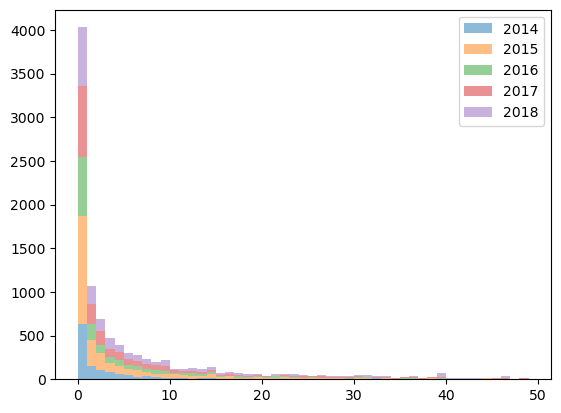

In [47]:
plt.hist(data_to_plot,  alpha=0.5, label=[2014,2015,2016,2017,2018], bins=range(0,50,1),stacked=True)
plt.legend(loc='upper right')

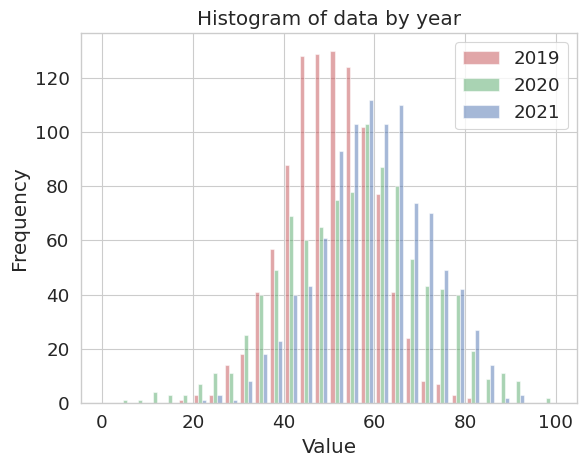

In [184]:
import matplotlib.pyplot as plt
import numpy as np

# Generate some sample data for different years
data_2019 = np.random.normal(50, 10, 1000)
data_2020 = np.random.normal(55, 15, 1000)
data_2021 = np.random.normal(60, 12, 1000)

# Combine the data into a list
data = [data_2019, data_2020, data_2021]

# Set the bins and range for the histogram
bins = 30
range = (0, 100)

# Plot the histogram
plt.hist(data, bins=bins, range=range, color=['r', 'g', 'b'], alpha=0.5, label=['2019', '2020', '2021'])
plt.legend(loc='upper right')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of data by year')
plt.show()
